# Training detection model to find task numbers using Detectron2

# Install detectron2

In [7]:
# install dependencies: 
#!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

# What version of Python do you have?
import sys
import platform
import torch
import pandas as pd
import sklearn as sk

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

2.0.0.dev20230224 False
Apple clang version 14.0.0 (clang-1400.0.29.202)
Target: arm64-apple-darwin22.3.0
Thread model: posix
InstalledDir: /Library/Developer/CommandLineTools/usr/bin
Python Platform: macOS-13.2.1-arm64-arm-64bit
PyTorch Version: 2.0.0.dev20230224

Python 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:38:11) 
[Clang 14.0.6 ]
Pandas 1.5.3
Scikit-Learn 1.2.1
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


In [8]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
torch.device("mps")     # for Apple Metal
#import detectron2
#assert torch.__version__.startswith("1.7")     # for colab
#!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

device(type='mps')

In [9]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow
from IPython import display
import PIL


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


def cv2_imshow(a):
    """A replacement for cv2.imshow() for use in Jupyter notebooks.
    Args:
    a : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. 
    shape (N, M, 3) is an NxM BGR color image. shape (N, M, 4) is an NxM BGRA color image.
    """
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display.display(PIL.Image.fromarray(a))

# Train on a custom dataset

## Prepare the dataset

In [10]:
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode

for d in ["train", "valid", "test"]:
    register_coco_instances(f"nucleus6x6_{d}", {},
                            f"datasets/6x6sample_augment/annotation/{d}.json",
                            f"datasets/6x6sample_augment/{d}")

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



WARNING [02/25 20:18:53 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/25 20:18:53 d2.data.datasets.coco]: Loaded 252 images in COCO format from datasets/6x6sample_augment/annotation/train.json


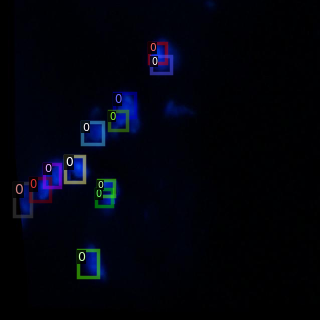

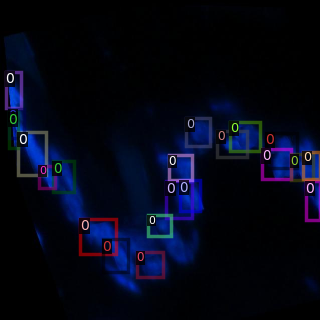

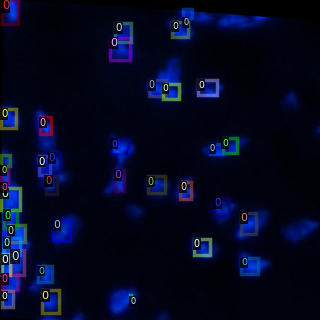

In [11]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("nucleus6x6_train")
dataset_dicts = DatasetCatalog.get("nucleus6x6_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train!


In [14]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
# for cpu only
cfg.MODEL.DEVICE = 'cpu'    # 'cpu' / 'gpu' (CUDA) / 'mps' (metal for Apple silicon)
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("nucleus6x6_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# uncomment below to train
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[02/25 20:23:12 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[02/25 20:23:12 d2.engine.train_loop]: Starting training from iteration 0
[02/25 20:24:33 d2.utils.events]:  eta: 11:18:04  iter: 19  total_loss: 2.376  loss_cls: 0.5503  loss_box_reg: 0  loss_rpn_cls: 1.635  loss_rpn_loc: 0.1882  time: 3.9659  last_time: 3.8002  data_time: 0.0536  last_data_time: 0.0007   lr: 4.9953e-06  
[02/25 20:25:56 d2.utils.events]:  eta: 11:43:23  iter: 39  total_loss: 1.557  loss_cls: 0.4771  loss_box_reg: 0  loss_rpn_cls: 0.8897  loss_rpn_loc: 0.1575  time: 4.0507  last_time: 3.4292  data_time: 0.0009  last_data_time: 0.0010   lr: 9.9902e-06  
[02/25 20:27:17 d2.utils.events]:  eta: 11:38:20  iter: 59  total_loss: 1.046  loss_cls: 0.3504  loss_box_reg: 0  loss_rpn_cls: 0.4897  loss_rpn_loc: 0.1815  time: 4.0491  last_time: 3.8286  data_time: 0.0009  last_data_time: 0.0009   lr: 1.4985e-05  
[02/25 20:28:36 d2.utils.events]:  eta: 11:31:36  iter: 79  total_loss: 0.6967  loss_cls: 0.2443  loss_box_reg: 0  loss_rpn_cls: 0.2901  loss_rpn_loc: 0.1591  time: 4.0252

KeyboardInterrupt: 

## Or load saved model

In [ ]:
# !wget "https://mipt.one/mediafiles/models/detectron2_miptone" -o "model_final.pth"

## TensorBoard

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir /kaggle/working/output

## Inference & evaluation using the trained model



In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
import pickle
with open("cfg.pkl", "wb") as f:
    pickle.dump(cfg, f)

Then, we randomly select several samples to visualize the prediction results.

In [ ]:
my_dataset_test_metadata = MetadataCatalog.get("physics_train")
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("physics_test")
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_dataset_test_metadata, 
                   scale=0.5, 
#                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~60. Not bad!

In [ ]:
# fix from https://github.com/facebookresearch/detectron2/issues/2484#issuecomment-759816895

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
#evaluator = COCOEvaluator("physics_test", ("bbox", "segm"), False, output_dir="./output/")
evaluator = COCOEvaluator("physics_test", ("bbox", ), False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "physics_test")
inference_on_dataset(trainer.model, test_loader, evaluator)
# another equivalent way to evaluate the model is to use `trainer.test`

## Exporting trained model weights for deployment

In [ ]:
import os
os.chdir(r'/kaggle/working')

from IPython.display import FileLink
FileLink(r'./output/model_final.pth')

In [ ]:
# from detectron2.modeling import build_model
# from detectron2.checkpoint import DetectionCheckpointer

# with open("cfg.pkl", "rb") as f:
#     cfg = pickle.load(f)

# model = build_model(cfg)
# DetectionCheckpointer(model).load(file_path_or_url)